# Compute probability of being correct

Using the volume-wise predictions computed with the SVC in the previous notebook, we now use the volume-wise data to make probabilistic decisions on the level of the patient. The number of agreeing volumes for the laterality group most often predicted (majority or relative majority vote) is used as input here to determine if there is a relationship between the number of agreeing volumes and the probability of getting the language lateralization of a patient right.

### import modules

In [1]:
import pickle

import numpy as np
import pandas as pd

from sklearn import metrics, linear_model

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('poster')

### get meta

In [3]:
data_df = pd.read_csv(
    '../data/processed/csv/info_epi_zscored_zdiff_summarymaps_2dpredclean_corr_counts_df.csv',
    index_col=[0, 1],
    header=0)

In [ ]:
data_df.tail()

### get the count data

In [5]:
def make_count_df(data_df, metric='counts_df'):
    '''count the number of volumes classified as left, bilateral or right'''

    count_df = pd.DataFrame()
    for p in data_df.index:

        filename = data_df.loc[p, metric]
        p_df = pd.read_csv(filename, index_col=[0, 1])
        count_df = pd.concat([count_df, p_df], sort=True)

    count_df = count_df.sort_index(axis=0)
    count_df = count_df.sort_index(axis=1)

    return count_df

In [6]:
count_df = make_count_df(data_df)

In [ ]:
count_df.tail()

### transform into proportions

In [8]:
proportion_df = make_count_df(data_df)/200.

In [ ]:
proportion_df.tail()

#### Example

In [10]:
p_group,p_name = proportion_df.index[-1]
p_name

'pat098'

In [ ]:
p_proportion_df = proportion_df.loc[[(p_group,p_name)]]
p_proportion_df

Descriptive statistics

In [12]:
proportion_df.groupby(level=0).aggregate(['count', 'mean', 'std']).round(2)

bilateral              left             right            
              count  mean   std count  mean   std count  mean   std
bilateral        14  0.33  0.06    14  0.31  0.12    14  0.36  0.11
left             59  0.25  0.07    59  0.46  0.13    59  0.29  0.10
right            23  0.27  0.08    23  0.26  0.09    23  0.47  0.14

### collect number of concordant volumes and WTA predictions

In [13]:
def make_metric_df(proportion_df):
    '''based on the proportion of agreeing volumes, get some summary
    statistics allowing to make decisions
    '''

    metric_df = proportion_df.copy()
    metric_df.loc[:, 'highest_num'] = metric_df.max(axis=1)
    metric_df.loc[:, 'highest_class'] = metric_df.idxmax(axis=1)

    metric_df.loc[:, 'true_class'] = metric_df.index.get_level_values(0)
    is_hit = (
        metric_df.loc[:, 'highest_class'] == metric_df.loc[:, 'true_class'])
    metric_df.loc[:, 'hit'] = is_hit

    return metric_df

In [14]:
metric_df = make_metric_df(proportion_df)

In [ ]:
metric_df.tail()

## Logistic Function Fit

In [16]:
def make_arrays(metric_df):
    '''to use with scikit-learn, we turn the pandas dataframes
    into numpy arrays
    '''
    
    X = metric_df.loc[:, 'highest_num'].values.reshape(-1, 1)
    y = metric_df.loc[:, 'hit'].values
    y_labels = metric_df.loc[:, 'true_class']
    
    return X, y, y_labels

In [17]:
metric_df = make_metric_df(proportion_df)

In [18]:
X, y, y_labels = make_arrays(metric_df)

In [19]:
X.shape, y.shape, y_labels.shape

((96, 1), (96,), (96,))

### fit logistic regression

In [20]:
def make_log_clf(X, y):
    ''''''

    clf = linear_model.LogisticRegression(C=1e5)
    clf.fit(X, y)

    return clf

In [21]:
clf = make_log_clf(X, y)

#### store classifier to file

In [22]:
with open('../models/log_clf.p', 'wb') as f:
    pickle.dump(clf, f)

#### Example behavior:

In [23]:
clf

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [24]:
clf.predict_proba([[0.1]])

array([[0.96280095, 0.03719905]])

### plot logistic regression

In [25]:
def make_log_curve(clf):
    
    def log_func(x):
        return 1 / (1 + np.exp(-x))

    curve_X = np.linspace(0, 1, 1000)
    curve_y = np.array(
        [log_func(i * clf.coef_ + clf.intercept_)[-1][-1] for i in curve_X])

    return curve_X, curve_y

In [26]:
curve_X, curve_y = make_log_curve(clf)

In [27]:
curve_X.shape,curve_y.shape

((1000,), (1000,))

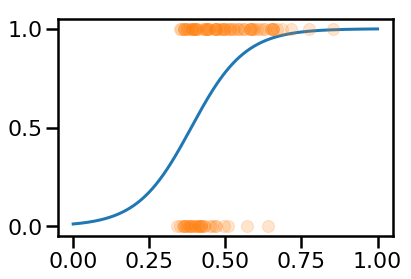

In [28]:
plt.plot(curve_X,curve_y)
plt.plot(X,y,'o',alpha=0.2)

### summary

We have moved from a classifier that makes decisions about volumes to a classifier that makes decisions about patients, based on the number of agreeing volumes in that patient's fMRI session.  
The logistic regression trained is rather simplistic and only considers the largest class of agreeing volumes, but not which type of lateralization is predicted, so ignores base rates and the fact that bilaterality seems to be more difficult to predict than the other groups. Keeping this limitation in mind, it can offer a suggestion about how likely a dataset with a certain number of agreeing volumes will be classified correctly on the patient level.


**************

< [Previous](10-mw-train-test-classifier.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](12-mw-make-correlation-plots-time.ipynb)